# installation et import

In [1]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity jackd musescore
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
0 upgraded, 6 newly installed, 0 to remove and 24 not upgraded.
Need to get 126 MB of archives.
After this operation, 157 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 timgm6mb-soundfont all 1.3-3 [5,420 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libfluidsynth2 amd64 2.1.1-2 [

In [2]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 72.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 7.3 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=20c6e4b626c5a4b9f3cbdca1142ff4eb3512d32575e3c960138373b6df279c8b
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [4]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import torch
import torchvision

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [5]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

# Chargemetn de données MIDI

nous allons dans les cellules suivante charger des données MIDI issue du dataset maestro [dataset maertro](https://magenta.tensorflow.org/datasets/maestro). Correspondant à 200h de MIDI de Piano.


In [6]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  torch.hub.download_url_to_file(
      'https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      'maestro-v2.0.0-midi.zip',
  )
  import zipfile
  with zipfile.ZipFile('maestro-v2.0.0-midi.zip', 'r') as zip_ref:
      zip_ref.extractall('data')

100%|██████████| 56.5M/56.5M [00:00<00:00, 148MB/s]


In [7]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [8]:
sample_file = filenames[3]
print(sample_file)

data/maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_22_R1_2015_wav--5.midi


## Lecture et affichage d'un morceau : 

In [9]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [10]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [11]:
display_audio(pm)

## Qu'est-ce qu'un MIDI ? 

In [12]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [13]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=47, note_name=B2, duration=0.0333
1: pitch=35, note_name=B1, duration=0.0438
2: pitch=35, note_name=B1, duration=0.6469
3: pitch=47, note_name=B2, duration=0.6656
4: pitch=37, note_name=C#2, duration=0.1125
5: pitch=49, note_name=C#3, duration=0.1125
6: pitch=51, note_name=D#3, duration=0.0542
7: pitch=39, note_name=D#2, duration=0.0479
8: pitch=52, note_name=E3, duration=0.0458
9: pitch=40, note_name=E2, duration=0.0646


## Traduction du MIDI en dataset 

In [14]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [15]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,35,0.950000,0.993750,0.000000,0.043750
1,47,0.953125,0.986458,0.003125,0.033333
2,47,1.042708,1.708333,0.089583,0.665625
3,35,1.050000,1.696875,0.007292,0.646875
4,37,1.712500,1.825000,0.662500,0.112500


In [16]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['B1', 'B2', 'B2', 'B1', 'C#2', 'C#3', 'D#3', 'D#2', 'E3', 'E2'],
      dtype='<U3')

## Affichage du morceau : 

In [17]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

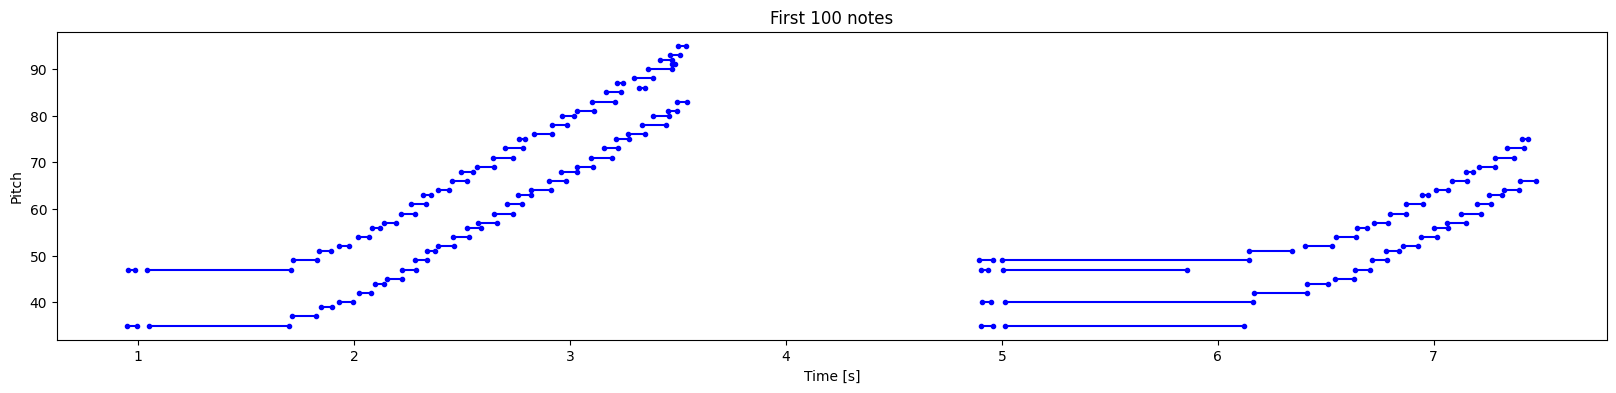

In [18]:
plot_piano_roll(raw_notes, count=100)

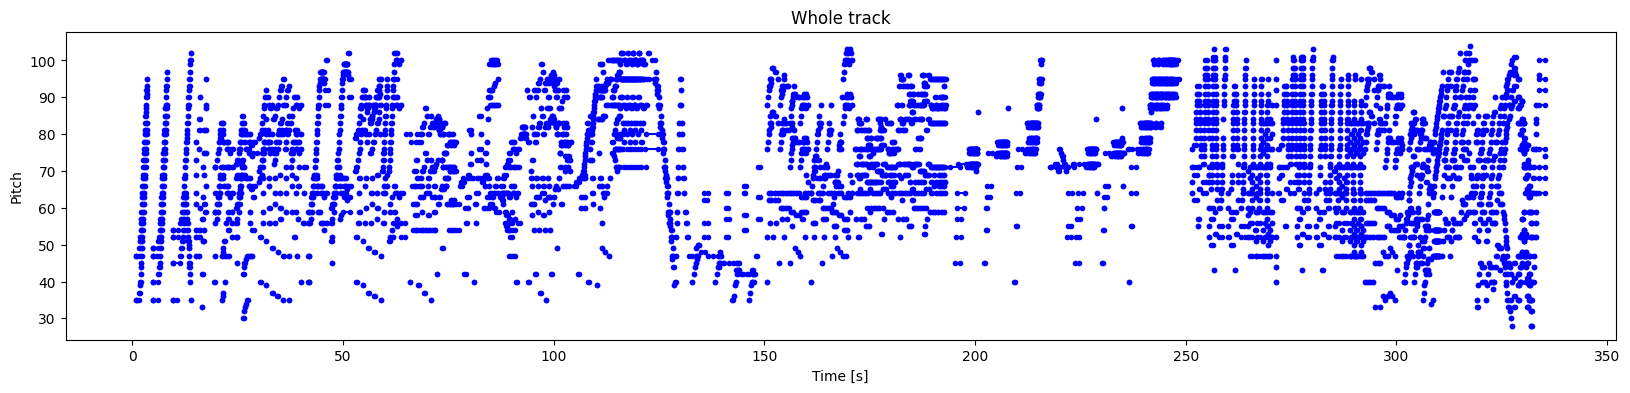

In [19]:
plot_piano_roll(raw_notes)

In [20]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

## fonction de re-génération de MIDI à partir des notes

In [21]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [22]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [23]:
display_audio(example_pm)

# Apprentissage d'un RNN joueur de piano

## Création d'un dataset

On va commencer par créer un petit jeux de donnée (ici 5 fichier midi seulement seront utiliser) :

In [24]:
len(filenames)

1282

In [ ]:
[filenames[i] for i in np.random.permutation(len(filenames))[:num_files]]

In [71]:
num_files = 50
all_notes = []
for f in [filenames[i] for i in np.random.permutation(len(filenames))[:num_files]]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [73]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 315971


In [74]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [75]:
train_notes_tensor = torch.tensor(train_notes)
notes_ds = torch.utils.data.TensorDataset(train_notes_tensor)
train_notes_tensor.shape

torch.Size([315971, 3])

### Définition du dataset pytorch

In [76]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, input_tensors, label_tensors):
        self.input_tensors = input_tensors
        self.label_tensors = label_tensors

    def __len__(self):
        return len(self.input_tensors)

    def __getitem__(self, idx):
        return self.input_tensors[idx], self.label_tensors[idx]
    
def create_sequences(
    dataset: torch.utils.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> torch.utils.data.Dataset:
  """Returns PyTorch Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = [dataset.tensors[0][i:i+seq_length] for i in range(len(dataset.tensors[0]) - seq_length + 1)]

  # Normalize note pitch
  def scale_pitch(x):
    x = x / torch.tensor([vocab_size, 1.0, 1.0])
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key: labels_dense[i] for i, key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  sequences = [split_labels(window) for window in windows]

  input_tensors = torch.stack([torch.tensor(seq[0],dtype=torch.float32) for seq in sequences])
  label_tensors = [{k: torch.tensor(v) for k, v in seq[1].items()} for seq in sequences]
  #label_tensors = [torch.tensor(seq[1]) for seq in sequences]

  return CustomDataset(input_tensors, label_tensors)

### Création du dataset pytorch


On va découper des bout de séquences de taille pré-définit lors de l'apprentissage :

In [77]:
seq_length = 80
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)

<ipython-input-76-4619621935c3>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensors = torch.stack([torch.tensor(seq[0],dtype=torch.float32) for seq in sequences])
<ipython-input-76-4619621935c3>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensors = [{k: torch.tensor(v) for k, v in seq[1].items()} for seq in sequences]


## Apprentissage 

In [78]:
from torch.utils.data import DataLoader, SubsetRandomSampler

batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset

# Create a SubsetRandomSampler for shuffling
sampler = SubsetRandomSampler(torch.randperm(buffer_size))

train_ds = DataLoader(seq_ds, batch_size=batch_size, sampler=sampler, drop_last=True, num_workers=0)

In [79]:
def mse_with_positive_pressure(y_true: torch.Tensor, y_pred: torch.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * torch.clamp(-y_pred, min=0.0)
    return torch.mean(mse + positive_pressure)

## définition du model :

In [80]:
import torch.nn as nn

class MusicModel(nn.Module):
    def __init__(self):
        super(MusicModel, self).__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=128, batch_first=True)
        self.fc_pitch = nn.Linear(128, 128)
        self.fc_step = nn.Linear(128, 1)
        self.fc_duration = nn.Linear(128, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        pitch = self.fc_pitch(x)
        step = self.fc_step(x)
        duration = self.fc_duration(x)
        return {'pitch': pitch, 'step': step, 'duration': duration}

input_shape = (seq_length, 3)
learning_rate = 0.005

model = MusicModel()

## Optimisation :

In [81]:
import torch.nn as nn
import torch.optim as optim


# Loss functions
criterion_pitch = nn.CrossEntropyLoss()
criterion_step = mse_with_positive_pressure
criterion_duration = mse_with_positive_pressure

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [82]:
import matplotlib.pyplot as plt

def train(model, dataloader, num_epochs, device):
    model.train()
    model.to(device)
    
    epoch_losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), {k: v.to(device) for k, v in labels.items()}
            optimizer.zero_grad()

            outputs = model(inputs)
            
            # Calculate losses
            loss_pitch = criterion_pitch(outputs['pitch'], labels['pitch'].long())
            loss_step = criterion_step(labels['step'], outputs['step'])
            loss_duration = criterion_duration(labels['duration'], outputs['duration'])
            loss = loss_pitch + loss_step + loss_duration
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        epoch_losses.append(epoch_loss)
        print(f"Epoch: {epoch+1}, Loss: {epoch_loss:.4f}")
    
    return epoch_losses


In [83]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 20

epoch_losses = train(model, train_ds, epochs, device)


Epoch: 1, Loss: 20137.2029
Epoch: 2, Loss: 19261.6307
Epoch: 3, Loss: 18907.0201
Epoch: 4, Loss: 18677.7631
Epoch: 5, Loss: 18527.6706
Epoch: 6, Loss: 18663.1973
Epoch: 7, Loss: 18134.9120
Epoch: 8, Loss: 20007.2376
Epoch: 9, Loss: 19855.4399
Epoch: 10, Loss: 20090.4433
Epoch: 11, Loss: 20638.4016
Epoch: 12, Loss: 20323.5244
Epoch: 13, Loss: 19885.9165
Epoch: 14, Loss: 19401.8944
Epoch: 15, Loss: 18841.2007
Epoch: 16, Loss: 18431.0136
Epoch: 17, Loss: 19247.7940
Epoch: 18, Loss: 19149.5975
Epoch: 19, Loss: 18489.7707
Epoch: 20, Loss: 18091.8736


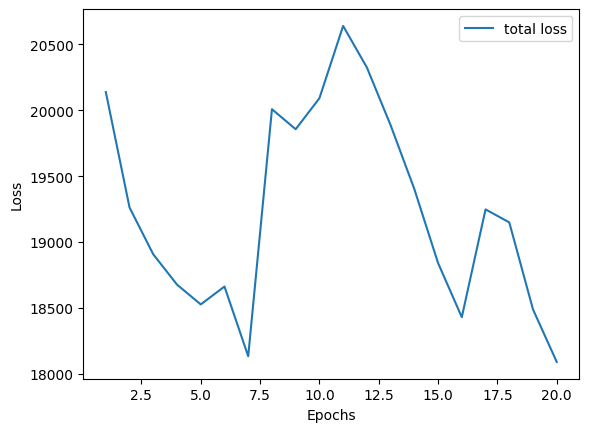

In [84]:
# Plot the loss
plt.plot(range(1, epochs+1), epoch_losses, label='total loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Test du model pour jouer de la musique : 

In [85]:
def predict_next_note(
    notes: np.ndarray, 
    pytorch_model: nn.Module, 
    device: torch.device,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension and convert to Tensor
  inputs = torch.unsqueeze(torch.tensor(notes, dtype=torch.float32), 0).to(device)

  with torch.no_grad():
      pytorch_model.eval()
      pytorch_model.to(device)
      predictions = pytorch_model(inputs)
      pitch_logits = predictions['pitch']
      step = predictions['step']
      duration = predictions['duration']
 
      pitch_logits /= temperature
      pitch = torch.multinomial(torch.softmax(pitch_logits, dim=1), num_samples=1)
      pitch = torch.squeeze(pitch, dim=-1)
      duration = torch.squeeze(duration, dim=-1)
      step = torch.squeeze(step, dim=-1)

      # `step` and `duration` values should be non-negative
      step = torch.clamp(step, min=0)
      duration = torch.clamp(duration, min=0)

  return int(pitch.item()), float(step.item()), float(duration.item())

Dans la cellule suivante nous allons prédire 900 notes de musiques,
la température définit un niveau de bruit :

In [101]:
temperature = 8
num_predictions = 900

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, device, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

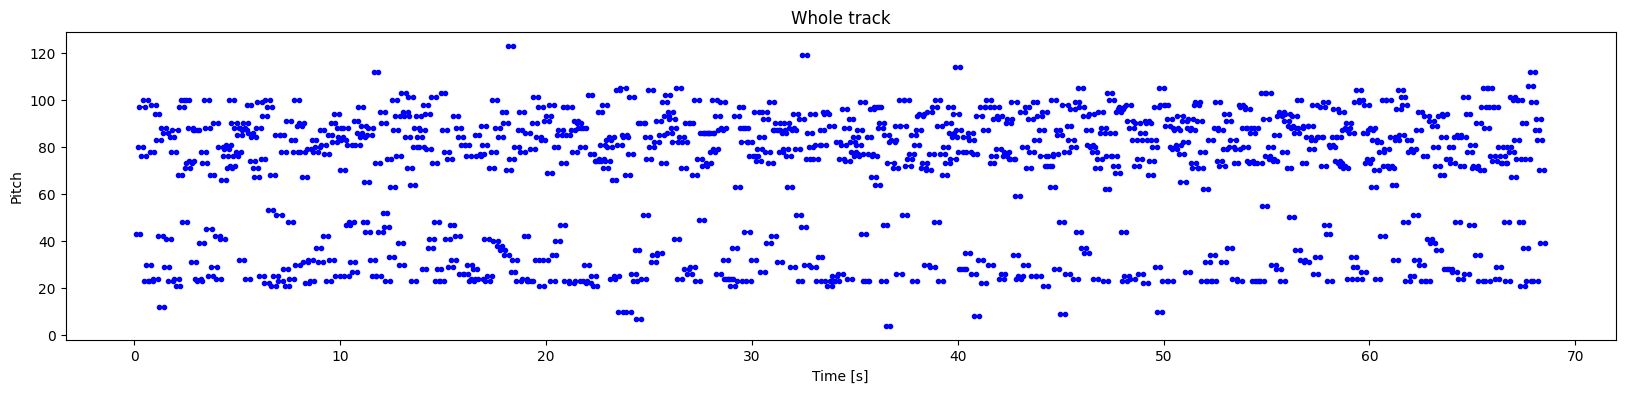

In [103]:
plot_piano_roll(generated_notes)

In [102]:
out_file = 'output3.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm, seconds=300)

Output hidden; open in https://colab.research.google.com to view.

## Affichage du résultat 

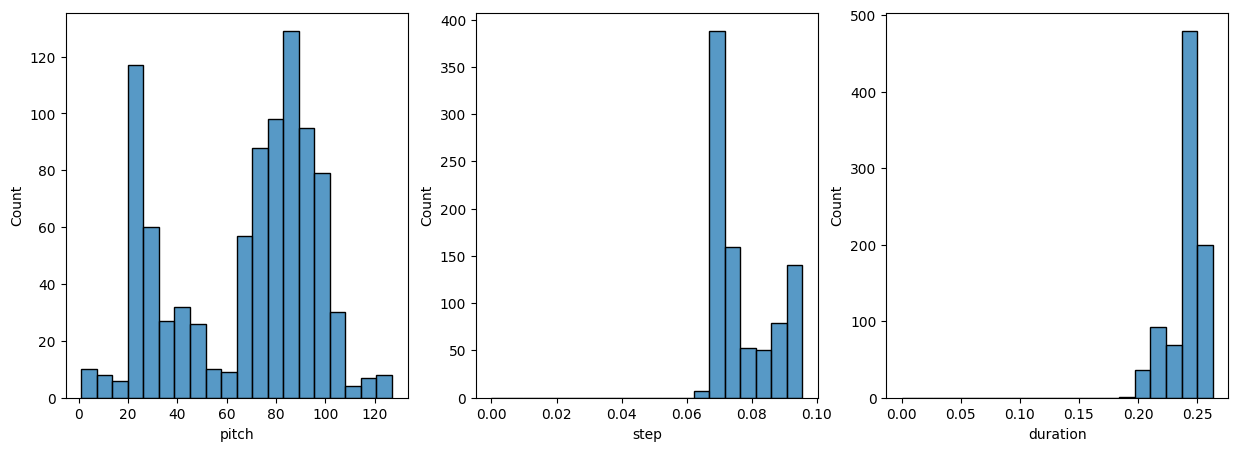

In [89]:
plot_distributions(generated_notes)

# Exercices 


1. Comment pourriez-vous améliorer la qualité des prédictions du modèle ? Essayez d'expérimenter avec différents paramètres du modèle, tels que la taille des couches cachées, le nombre d'époques d'entraînement, le taux d'apprentissage, etc.
1. Comment pourriez-vous intégrer des informations supplémentaires, telles que la vélocité (intensité) des notes, dans le modèle ? Modifiez la structure du modèle et les fonctions de préparation des données pour prendre en compte ces informations supplémentaires.
1. Essayez d'implémenter des métriques d'évaluation pour mesurer la qualité des prédictions du modèle, par exemple en comparant les séquences générées avec des séquences de musique réelles. Comment pourriez-vous utiliser ces métriques pour améliorer le modèle ?
1. Évaluez l'impact de la température sur la génération de la musique. Générez des séquences avec différentes valeurs de température et comparez les résultats. Quelle est l'influence de la température sur la diversité et la cohérence des séquences générées ?
1. Évaluer l'impacte de la longeur de la séquence dans la construction du dataset
1. Tester un autre RNN (par exemple des Cellules GRU à la place du LSTM).